# Evaluation of SFINCS vs HAND

Let's plot the HAND output for this location
- Generated from FIM-C PI3 test procedure

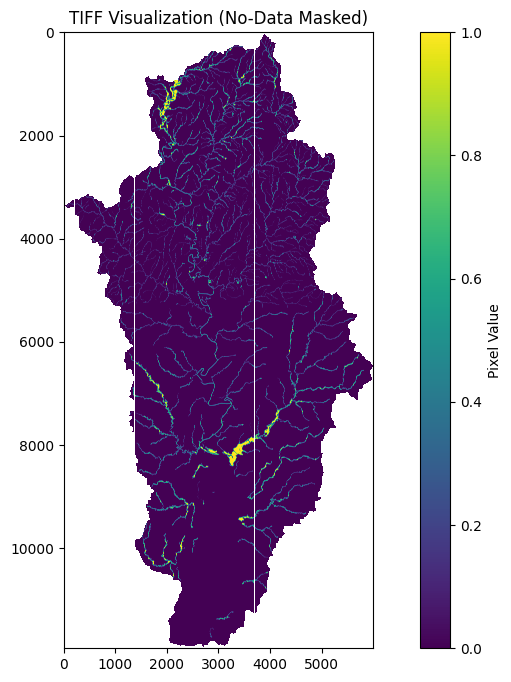

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio

hand_tif = "/app/data/SFINCS/ngwpc_data/gis/output_binary_hand.tif"

# Open the file
with rasterio.open(hand_tif) as src:
    # Read the data
    data = src.read(1)  # Read the first band
    
    # Create a masked array
    masked_data = ma.masked_equal(data, 255)
    
    # Get the actual min and max values, ignoring no-data
    vmin, vmax = np.percentile(masked_data.compressed(), [2, 98])
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the data with improved color scaling
    im = ax.imshow(masked_data, cmap='viridis', vmin=vmin, vmax=vmax)
    
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Pixel Value')
    
    # Set the title
    ax.set_title('TIFF Visualization (No-Data Masked)')
    
    # Show the plot
    plt.show()

### Let's zoom in on the area of interest to see how HAND mapped the event

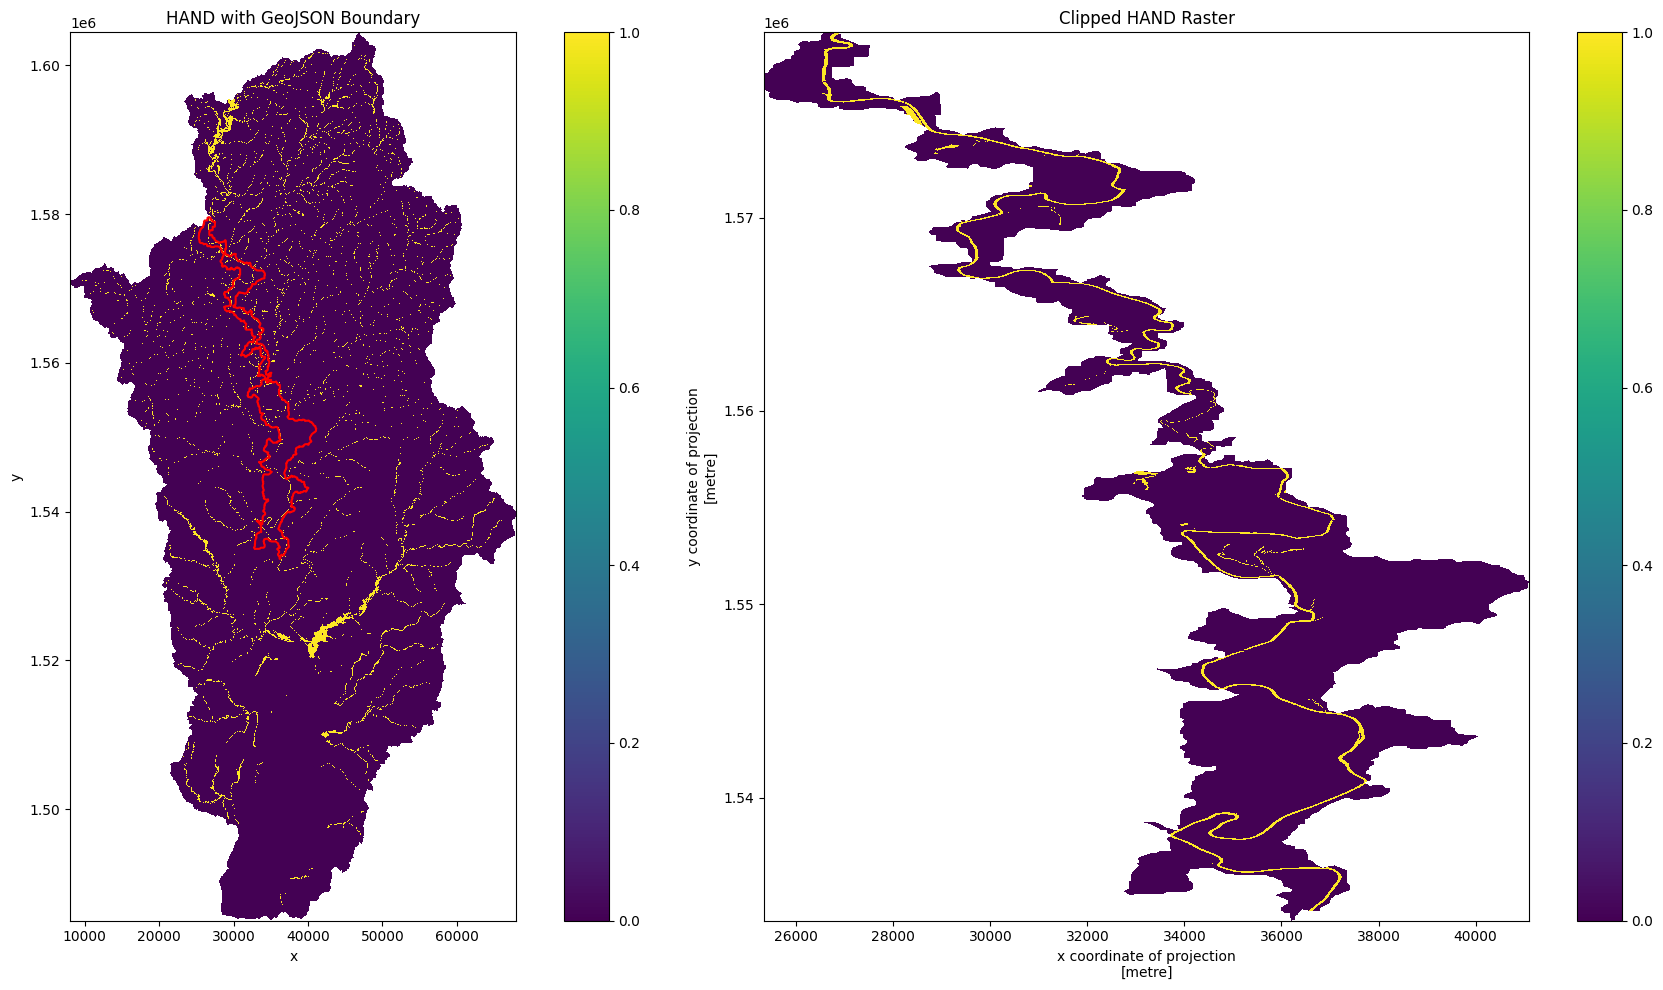

In [2]:
import rioxarray as rxr
import geopandas as gpd

clipped_path = "/app/data/SFINCS/ngwpc_data/gis/output_binary_hand_clipped.tif"
raster = rxr.open_rasterio(hand_tif)

if raster.shape[0] > 1:
    raster = raster[0]

# Set the no-data value
raster = raster.where(raster != 255)

# Read the GeoJSON file
gdf_hand = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")

# Ensure the GeoDataFrame has the same CRS as the raster
gdf_hand = gdf_hand.to_crs(raster.rio.crs)

# Clip the raster with the GeoJSON geometry
clipped_hand = raster.rio.clip(gdf_hand.geometry, gdf_hand.crs)
clipped_hand.rio.to_raster(clipped_path, dtype="uint8")

clipped_hand = clipped_hand.where(clipped_hand != 255)

# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot original raster
im1 = raster.plot(ax=ax1, cmap='viridis', vmin=raster.min(), vmax=raster.max())
gdf_hand.boundary.plot(ax=ax1, color='red')
ax1.set_title('HAND with GeoJSON Boundary')

# Plot clipped raster
im2 = clipped_hand.plot(ax=ax2, cmap='viridis', vmin=clipped_hand.min(), vmax=clipped_hand.max())
ax2.set_title('Clipped HAND Raster')

plt.tight_layout()
plt.show()

### Let's see the SFINCS output in this location

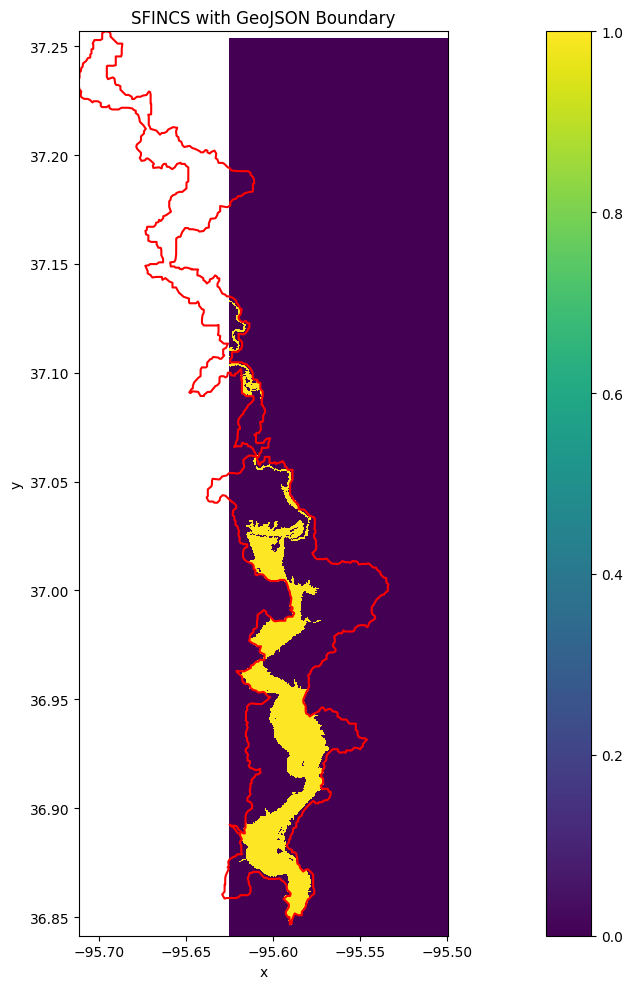

In [12]:
import rioxarray as rxr
import geopandas as gpd

sfincs_tif = "/app/data/SFINCS/ngwpc_data/gis/output_binary_sfincs.tif"
raster_sfincs = rxr.open_rasterio(sfincs_tif)

if raster_sfincs.shape[0] > 1:
    raster_sfincs = raster_sfincs[0]

# Set the no-data value
raster_sfincs = raster_sfincs.where(raster_sfincs != 255)

# Read the GeoJSON file
gdf = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")

# Ensure the GeoDataFrame has the same CRS as the raster
gdf = gdf.to_crs(raster_sfincs.rio.crs)

# # Clip the raster with the GeoJSON geometry
# clipped_sfincs = raster_sfincs.rio.clip(gdf.geometry, gdf.crs)

# clipped_sfincs = clipped_sfincs.where(clipped_sfincs != 255)

# Plot the result
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))

# Plot original raster
im1 = raster_sfincs.plot(ax=ax1, cmap='viridis')
gdf.boundary.plot(ax=ax1, color='red')
ax1.set_title('SFINCS with GeoJSON Boundary')

minx, miny, maxx, maxy = gdf.total_bounds
ax1.set_xlim(min(raster_sfincs.x.min(), minx), max(raster_sfincs.x.max(), maxx))
ax1.set_ylim(min(raster_sfincs.y.min(), miny), max(raster_sfincs.y.max(), maxy))

# # Plot clipped raster
# im2 = clipped.plot(ax=ax2, cmap='viridis', vmin=clipped.min(), vmax=clipped.max())
# ax2.set_title('Clipped SFINCS Raster')

plt.tight_layout()
plt.show()

### Using GVAL, we can compare the two 

We relied on FIM-C's inundation mapping container to run GVAL to compare the images. The intructions to start their eval_mvp container are within their UAT document. The commands below were used in their container. We did not make a script as we did not want to save any codes within their deliverables. Hence, the command line was used

```sh
root@mgmt-taddbindas-oefimevalvizrtxoecopytb-00001:/foss_fim/tools
Python 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import tools_shared_functions
>>> stat_dict = tools_shared_functions.get_stats_table_from_binary_rasters("/fim_temp/output_binary_hand.tif", "/fim_temp/output_binary_sfincs.tif", agreement_raster="/fim_temp/hand_sfincs_agreement.tif")
/usr/local/lib/python3.10/dist-packages/gval/comparison/agreement.py:134: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  agreement_map.rio.set_crs(crs, inplace=True)
>>> stat_dict
{'total_area': {'false_negatives_count': 0.0, 'false_positives_count': 114985.0, 'true_negatives_count': 0.0, 'true_positives_count': 3341.0, 'ACC': 0.02823555262579653, 'Bal_ACC': 0.5, 'CSI': 0.02823555262579653, 'EQUITABLE_THREAT_SCORE': 0.0, 'F1_SCORE': 0.054920397478363074, 'FAR': 0.9717644473742034, 'PND': 0.0, 'FALSE_OMISSION_RATE': nan, 'FALSE_POSITIVE_RATE': 1.0, 'FOWLKES_MALLOW_INDEX': 0.16803437929720372, 'MCC': nan, 'NEGATIVE_LIKELIHOOD_RATIO': nan, 'NPV': nan, 'BIAS': 35.416342412451364, 'POSITIVE_LIKELIHOOD_RATIO': 1.0, 'PPV': 0.02823555262579653, 'PREVALENCE': 0.02823555262579653, 'PREVALENCE_THRESHOLD': 0.5, 'TNR': 0.0, 'TPR': 1.0, 'contingency_tot_count': 118326.0, 'TP_perc': 2.823555262579653, 'FP_perc': 97.17644473742034, 'TN_perc': 0.0, 'FN_perc': 0.0, 'cell_area_m2': 100.0, 'TP_area_km2': 0.3341, 'FP_area_km2': 11.4985, 'TN_area_km2': 0.0, 'FN_area_km2': 0.0, 'contingency_tot_area_km2': 11.8326, 'predPositive_area_km2': 11.8326, 'predNegative_area_km2': 0.0, 'obsPositive_area_km2': 0.3341, 'obsNegative_area_km2': 11.4985, 'positiveDiff_area_km2': 11.4985, 'masked_count': 0.0, 'masked_perc': 0.0, 'masked_area_km2': 0.0, 'predPositive_perc': 100.0, 'predNegative_perc': 0.0, 'obsPositive_perc': 2.823555262579653, 'obsNegative_perc': 97.17644473742034, 'positiveDiff_perc': 97.17644473742035}}
```

we'll plot the agreement matrix below

In [ ]:
import rioxarray as rxr
import geopandas as gpd

agreement_tif = "/app/data/SFINCS/ngwpc_data/gis/hand_sfincs_agreement.tif"
raster = rxr.open_rasterio(agreement_tif)

if raster.shape[0] > 1:
    raster = raster[0]

# Set the no-data value
raster = raster.where(raster != 255)

# Read the GeoJSON file
gdf = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")

# Ensure the GeoDataFrame has the same CRS as the raster
gdf = gdf.to_crs(raster.rio.crs)

# Clip the raster with the GeoJSON geometry
clipped = raster.rio.clip(gdf.geometry, gdf.crs)

clipped = clipped.where(clipped != 255)

# Plot the result
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))

# Plot original raster
im1 = raster.plot(ax=ax1, cmap='viridis')
gdf.boundary.plot(ax=ax1, color='red')
ax1.set_title('Agreement matrix with GeoJSON Boundary')

# # Plot clipped raster
# im2 = clipped.plot(ax=ax2, cmap='viridis', vmin=clipped.min(), vmax=clipped.max())
# ax2.set_title('Clipped SFINCS Raster')

plt.tight_layout()
plt.show()

### What about remotely sensed benchmarks?

We have flood extent Sentinel-2 data (Courtesy of the SI-2024 Code: https://github.com/NWC-CUAHSI-Summer-Institute/FLDSensing), however, more work needs to be done to make the flood extent work for GVAL. Below, we can see the flood extent compared with the HAND FIM and SFINCS to see the differences. 

In [ ]:
raster_rs = rxr.open_rasterio("/app/data/SFINCS/ngwpc_data/gis/coffeyville_flood_extent.tif")

if raster_rs.shape[0] > 1:
    raster_rs = raster_rs[0]

# Set 0 as no-data value
raster_rs = raster_rs.where(raster_rs != 0)

# Convert raster to WGS84
gdf = gpd.read_file("/app/data/NWM/flowlines_divides.geojson")
gdf = gdf.to_crs(raster_rs.rio.crs)

# Plot the result
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

# Plot HAND raster (assuming clipped_hand is defined elsewhere in your code)
im1 = clipped_hand.plot(ax=ax1, cmap='viridis', vmin=clipped_hand.min(), vmax=clipped_hand.max())
ax1.set_title('Clipped HAND Raster')

# Plot SFINCS raster (assuming raster_sfincs and gdf_sfincs are defined elsewhere)
im2 = raster_sfincs.plot(ax=ax2, cmap='viridis')
gdf_sfincs.boundary.plot(ax=ax2, color='red')
ax2.set_title('SFINCS with GeoJSON Boundary')

# Plot the converted binary raster
viridis_r = plt.cm.viridis.reversed()
im3 = raster_rs.plot(ax=ax3, cmap=viridis_r, vmin=0, vmax=1)
gdf.boundary.plot(ax=ax3, color='red')
ax3.set_title('RS Flood extent (WGS84) with GeoJSON Boundary')

plt.tight_layout()
plt.show()

### Conclusions

We can see that SFINCS is able to generate higher flows than HAND. We suspect this is due to a lack of subgrid definition (roughness, channel width, channel depth. We are coordinating with Deltares' HydroMT and SFINCS teams in order to get subgrid definitions working with the latest docker images. 